In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import joblib
import sklearn
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
%matplotlib inline

2023-04-23 16:12:40.929674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 16:12:50.504531: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda-11/lib64
2023-04-23 16:12:50.504725: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIB

## data preprocessing

In [3]:
with tf.device("/cpu:0"):
    data_x=joblib.load("data_lz4_RT_TF.p")
    data_y=joblib.load("data_lz4_Y_NP.p")

2023-04-18 20:39:36.948601: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda-11/lib64
2023-04-18 20:39:36.978387: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda-11/lib64
2023-04-18 20:39:36.978669: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to 

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


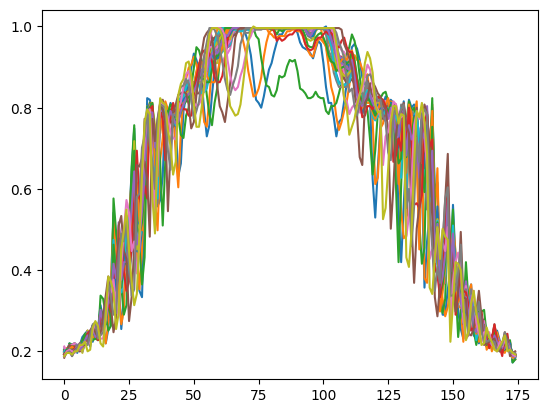

In [3]:
length=int(tf.shape(data_x[1][0])[0])
for v in data_x[1][:39]:
    matplotlib.pyplot.plot(v[length//2].numpy())
print(data_y[1])
    #print(data_x[i][:][].numpy().shape)

In [7]:
with tf.device("/cpu:0"):
    x=[]
    y=[]
    num_of_data=int(tf.shape(data_x)[0])
    indices=tf.random.shuffle(tf.range(start=0, limit=num_of_data, dtype=tf.int32))
    data_x=tf.gather(data_x, indices)
    data_y=tf.gather(data_y, indices)

In [14]:
with tf.device("/cpu:0"):
    x = []
    y = []
    for data_pos in range(num_of_data):
        data_shape=tf.shape(data_x[data_pos])
        mid_strip=175 // 2

        x.append(data_x[data_pos, :, mid_strip])
        y.append(data_y[data_pos])
            
    len_map = list(map(len, x))
    x = np.vstack(x)
    x = tf.RaggedTensor.from_row_lengths(x, len_map)[..., tf.newaxis]
    y = np.array(y)


In [16]:
print(x.shape, y.shape)

(2583, None, 175, 1) (2583, 27)


In [17]:
joblib.dump(x, "data_x_1D.p")
joblib.dump(y, "data_y_1D.p")

['data_y_1D.p']

## run here

In [154]:
x = joblib.load("data_x_1D.p")
y = joblib.load("data_y_1D.p")
print(x.shape, y.shape)

(2583, None, 175, 1) (2583, 27)


In [26]:
def under_sample(inputs, labels, cap_val=60, shuffle=True):
    with tf.device("/cpu:0"):
        counter = defaultdict(int)
        indexes = sklearn.utils.shuffle(range(inputs.shape[0])) if shuffle else range(len(inputs))
        out_input = []
        out_label = []
        for ind in indexes:
            la = np.where(labels[ind] == 1)[0][0]
            counter[la] += 1
            if counter[la] <= cap_val:
                out_input.append(inputs[ind])
                out_label.append(labels[ind])
        del inputs, labels
        len_map = list(map(len, out_input))
        out_input = [im for d in out_input for im in d]
        return tf.RaggedTensor.from_row_lengths(
                    out_input,
                    row_lengths=len_map
                ), np.array(out_label)

In [27]:
def split_ragged_tensor(x, y, val_fraction=0.2, seed=None):
    # compute the number of rows in the input tensors
    n_rows = x.shape[0]

    # compute the number of rows to use for validation
    n_val_rows = int(n_rows * val_fraction)

    # set the random seed for reproducibility
    if seed is not None:
        tf.random.set_seed(seed)

    # shuffle the rows of the tensors randomly
    shuffled_indices = tf.random.shuffle(tf.range(n_rows))
    x = tf.gather(x, shuffled_indices)
    y = tf.gather(y, shuffled_indices)

    # split the tensors into training and validation sets
    x_train = x[n_val_rows:, :]
    x_val = x[:n_val_rows, :]
    y_train = y[n_val_rows:]
    y_val = y[:n_val_rows]

    return x_train, x_val, y_train, y_val

In [28]:
def smooth_labels(labels, factor=0.1):
        # smooth the labels
        labels *= (1 - factor)
        labels += (factor / labels.shape[1])
        # returned the smoothed labels
        return labels

In [155]:
x, y = under_sample(x, y)
x_train, x_test, y_train, y_test = split_ragged_tensor(x,
                                                       y,
                                                       val_fraction=0.2,
                                                       seed=42)
x_train, x_valid, y_train, y_valid = split_ragged_tensor(x_train,
                                                         y_train,
                                                         val_fraction=0.2,
                                                         seed=42)

In [156]:
y_train = smooth_labels(y_train)

In [157]:
# max allowed timesteps is 200
x_train = (x_train).to_tensor(default_value=-1.0, shape=[None, 200, 175, 1])[..., 0]
x_valid = (x_valid).to_tensor(default_value=-1.0, shape=[None, 200, 175, 1])[..., 0]
x_test = (x_test).to_tensor(default_value=-1.0, shape=[None, 200, 175, 1])[..., 0]

In [32]:
x_train = tf.cast(tf.cast(x_train, tf.uint8), tf.float32)
x_valid = tf.cast(tf.cast(x_valid, tf.uint8), tf.float32)
x_test = tf.cast(tf.cast(x_test, tf.uint8), tf.float32)

In [158]:
print(
    tf.reduce_max(x_train).numpy(), 
    tf.reduce_max(x_test).numpy(), 
    tf.reduce_max(x_valid).numpy(),
    tf.reduce_min(x_train).numpy(), 
    tf.reduce_min(x_test).numpy(), 
    tf.reduce_min(x_valid).numpy()
)

1.0 1.0 1.0 -1.0 -1.0 -1.0


In [159]:
print(x_train.shape, y_train.shape)

(858, 200, 175) (858, 27)


In [59]:
drop_rate = 0.3
cnn = keras.Sequential([
    layers.Conv1D(16, 4),
    layers.MaxPooling1D(),
    layers.Dropout(drop_rate),
    layers.Conv1D(16, 4),
    layers.MaxPooling1D(),
    layers.Dropout(drop_rate),
    layers.Conv1D(32, 4),
    layers.MaxPooling1D(),
    layers.Dropout(drop_rate),
    layers.Conv1D(64, 4),
    layers.MaxPooling1D(),
    layers.Dropout(drop_rate),
])

inp=tf.keras.Input(shape=(None, 175,1))
conv=tf.keras.layers.TimeDistributed(cnn)(inp)
fl = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(conv)
lstm=tf.keras.layers.LSTM(32, kernel_regularizer='l2')(fl)
fc = tf.keras.layers.Dense(27, activation="softmax")(lstm)

model = tf.keras.Model(inputs=[inp], outputs=[fc])

model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, None, 175,   0           []                               
                                1)]                                                               
                                                                                                  
 time_distributed_30 (TimeDistr  (None, None, 8, 64)  11456      ['input_16[0][0]']               
 ibuted)                                                                                          
                                                                                                  
 time_distributed_31 (TimeDistr  (None, None, 512)   0           ['time_distributed_30[0][0]']    
 ibuted)                                                                                   

In [88]:
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

In [89]:
from keras.layers import Input, LSTM, Dense, Dropout, Masking, BatchNormalization, GlobalAveragePooling1D
from keras.models import Model
from keras.layers.attention import Attention

# Define input shape
input_shape = (200, 175)
lstm_units = 128
max_len = 100
d_emb = 175

# Define model architecture
inputs = Input(shape=input_shape)
mask_layer = Masking(mask_value=0.0)(inputs)
pos_encoding_layer = PositionalEncoder(175)(mask_layer)
lstm_outputs = LSTM(units=lstm_units, return_sequences=True, kernel_regularizer="l2")(pos_encoding_layer)

attention_outputs = Attention()([lstm_outputs, lstm_outputs])
batch_norm_outputs = BatchNormalization(momentum=0.1)(attention_outputs)
pooled_outputs = GlobalAveragePooling1D()(batch_norm_outputs)
dense_outputs = Dense(units=64, activation='relu')(pooled_outputs)
dense_outputs = Dropout(0.1)(dense_outputs)
dense_outputs = Dense(units=27, activation='softmax')(dense_outputs)

# Build and compile model
model = Model(inputs=inputs, outputs=dense_outputs)

# Print model summary
model.summary()


Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 200, 175)]   0           []                               
                                                                                                  
 masking_22 (Masking)           (None, 200, 175)     0           ['input_23[0][0]']               
                                                                                                  
 positional_encoder_5 (Position  (None, 200, 175)    35000       ['masking_22[0][0]']             
 alEncoder)                                                                                       
                                                                                                  
 lstm_15 (LSTM)                 (None, 200, 128)     155648      ['positional_encoder_5[0][

In [90]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train,y=y_train,epochs=300, batch_size=32, validation_data=(x_valid, y_valid))

Epoch 1/300
27/27 [==============================] - 5s 133ms/step - loss: 5.7335 - accuracy: 0.0944 - val_loss: 5.5757 - val_accuracy: 0.1121
Epoch 2/300
27/27 [==============================] - 3s 120ms/step - loss: 5.4730 - accuracy: 0.1422 - val_loss: 5.3578 - val_accuracy: 0.1075
Epoch 3/300
27/27 [==============================] - 3s 122ms/step - loss: 5.2625 - accuracy: 0.1702 - val_loss: 5.0977 - val_accuracy: 0.1822
Epoch 4/300
27/27 [==============================] - 3s 121ms/step - loss: 5.0626 - accuracy: 0.1795 - val_loss: 4.9298 - val_accuracy: 0.2383
Epoch 5/300
27/27 [==============================] - 3s 121ms/step - loss: 4.8474 - accuracy: 0.2389 - val_loss: 4.7175 - val_accuracy: 0.1963
Epoch 6/300
27/27 [==============================] - 3s 120ms/step - loss: 4.6261 - accuracy: 0.2599 - val_loss: 4.4469 - val_accuracy: 0.2056
Epoch 7/300
27/27 [==============================] - 3s 120ms/step - loss: 4.4346 - accuracy: 0.2506 - val_loss: 4.2602 - val_accuracy: 0.2056

Epoch 58/300
27/27 [==============================] - 3s 120ms/step - loss: 1.7824 - accuracy: 0.6876 - val_loss: 1.8101 - val_accuracy: 0.5000
Epoch 59/300
27/27 [==============================] - 3s 120ms/step - loss: 1.7936 - accuracy: 0.6795 - val_loss: 1.7826 - val_accuracy: 0.5514
Epoch 60/300
27/27 [==============================] - 3s 120ms/step - loss: 1.7770 - accuracy: 0.7098 - val_loss: 1.5394 - val_accuracy: 0.6682
Epoch 61/300
27/27 [==============================] - 3s 120ms/step - loss: 1.7762 - accuracy: 0.6993 - val_loss: 1.8699 - val_accuracy: 0.5374
Epoch 62/300
27/27 [==============================] - 3s 119ms/step - loss: 1.7722 - accuracy: 0.7016 - val_loss: 1.7768 - val_accuracy: 0.5234
Epoch 63/300
27/27 [==============================] - 3s 122ms/step - loss: 1.7536 - accuracy: 0.6958 - val_loss: 1.5604 - val_accuracy: 0.5841
Epoch 64/300
27/27 [==============================] - 3s 120ms/step - loss: 1.8145 - accuracy: 0.6783 - val_loss: 2.0928 - val_accuracy:

Epoch 115/300
27/27 [==============================] - 3s 120ms/step - loss: 1.5726 - accuracy: 0.7343 - val_loss: 1.2683 - val_accuracy: 0.6776
Epoch 116/300
27/27 [==============================] - 3s 120ms/step - loss: 1.5625 - accuracy: 0.7249 - val_loss: 1.3995 - val_accuracy: 0.6308
Epoch 117/300
27/27 [==============================] - 3s 120ms/step - loss: 1.5929 - accuracy: 0.7179 - val_loss: 1.6448 - val_accuracy: 0.5654
Epoch 118/300
27/27 [==============================] - 3s 122ms/step - loss: 1.5509 - accuracy: 0.7331 - val_loss: 1.5293 - val_accuracy: 0.5935
Epoch 119/300
27/27 [==============================] - 3s 120ms/step - loss: 1.5202 - accuracy: 0.7517 - val_loss: 1.9733 - val_accuracy: 0.4112
Epoch 120/300
27/27 [==============================] - 3s 120ms/step - loss: 1.5885 - accuracy: 0.7110 - val_loss: 1.4888 - val_accuracy: 0.5888
Epoch 121/300
27/27 [==============================] - 3s 120ms/step - loss: 1.5487 - accuracy: 0.7343 - val_loss: 1.4699 - val_ac

27/27 [==============================] - 3s 121ms/step - loss: 1.3472 - accuracy: 0.7890 - val_loss: 1.2618 - val_accuracy: 0.6355
Epoch 228/300
27/27 [==============================] - 3s 121ms/step - loss: 1.3774 - accuracy: 0.7704 - val_loss: 1.1995 - val_accuracy: 0.6822
Epoch 229/300
27/27 [==============================] - 3s 121ms/step - loss: 1.2914 - accuracy: 0.8147 - val_loss: 1.1444 - val_accuracy: 0.6963
Epoch 230/300
27/27 [==============================] - 3s 121ms/step - loss: 1.3547 - accuracy: 0.8019 - val_loss: 1.0408 - val_accuracy: 0.7477
Epoch 231/300
27/27 [==============================] - 3s 121ms/step - loss: 1.3054 - accuracy: 0.7949 - val_loss: 1.9998 - val_accuracy: 0.4533
Epoch 232/300
27/27 [==============================] - 3s 121ms/step - loss: 1.2825 - accuracy: 0.8065 - val_loss: 1.1657 - val_accuracy: 0.6776
Epoch 233/300
27/27 [==============================] - 3s 121ms/step - loss: 1.2757 - accuracy: 0.8054 - val_loss: 1.7452 - val_accuracy: 0.5514

In [58]:
MODEL_NAME = "lstm128_attention_epoch300_dense64_drop1_bnorm1_int"
model.save(f"models/{MODEL_NAME}.h5")

## plotting

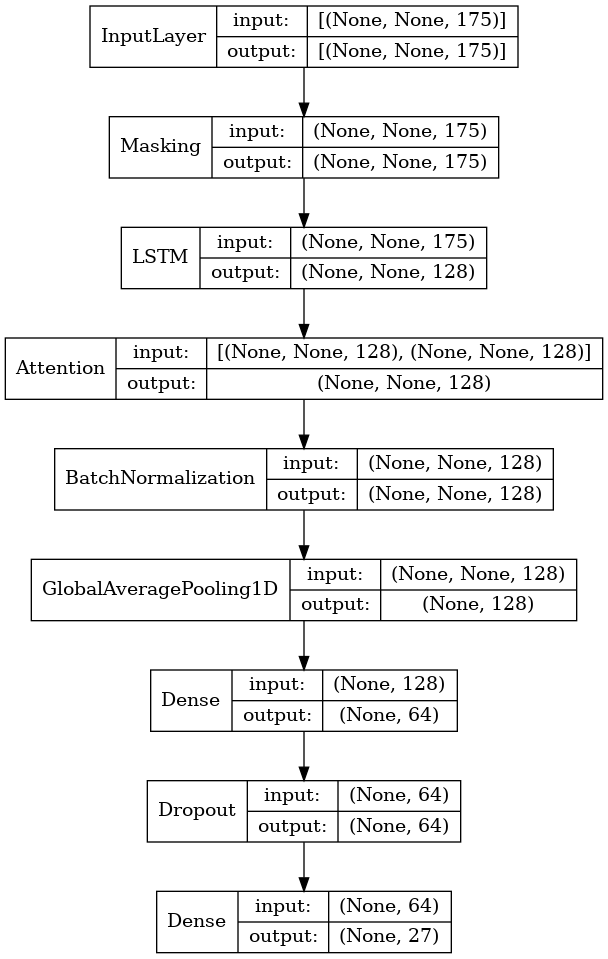

In [80]:
keras.utils.plot_model(model, show_layer_names=False, show_shapes=True)

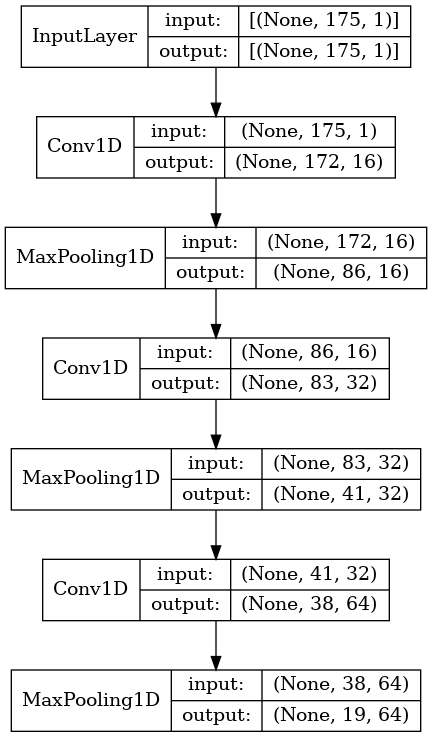

In [68]:
keras.utils.plot_model(cnn, show_layer_names=False, show_shapes=True)

In [79]:
model.evaluate(x_test, y_test)

9/9 [==============================] - 1s 54ms/step - loss: 0.6094 - accuracy: 0.8727


[0.6093945503234863, 0.8726591467857361]

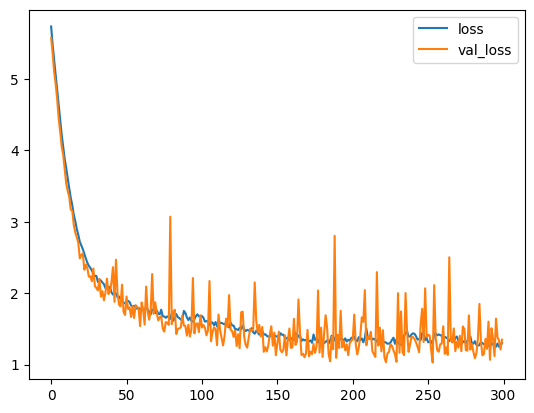

In [91]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

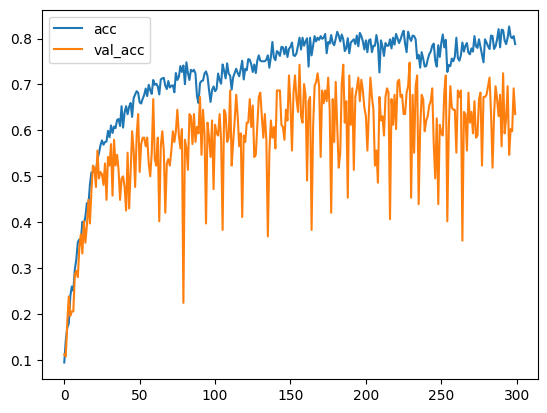

In [92]:
plt.plot(history.history["accuracy"], label="acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.show()

predicting test data
9/9 [==============================] - 1s 55ms/step
making confussion matrix


<AxesSubplot: >

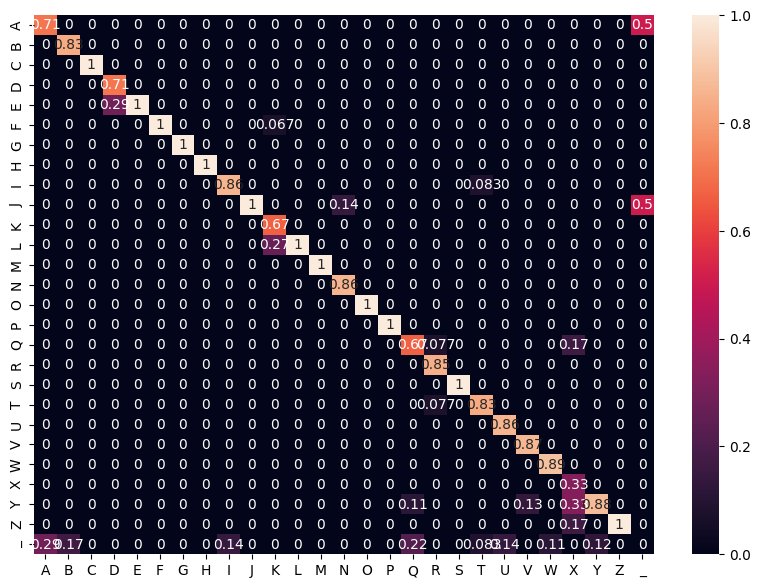

In [78]:
print("predicting test data")
y_prediction = model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
y_tt = np.argmax(y_test, axis=1)
print("making confussion matrix")
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_tt, y_prediction , normalize='pred')

df_cm = pd.DataFrame(result, index=[i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ_"],
                     columns=[i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ_"])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True)

## quantization

<tf.RaggedTensor [[[[0.2],
   [0.20784314],
   [0.21176471],
   ...,
   [0.18431373],
   [0.19215687],
   [0.18039216]],

  [[0.19215687],
   [0.20784314],
   [0.21176471],
   ...,
   [0.18431373],
   [0.19215687],
   [0.18039216]],

  [[0.2],
   [0.20784314],
   [0.21176471],
   ...,
   [0.1764706],
   [0.1882353],
   [0.1764706]],

  ...,

  [[0.22352941],
   [0.21176471],
   [0.21568628],
   ...,
   [0.18039216],
   [0.1882353],
   [0.1764706]],

  [[0.2],
   [0.22352941],
   [0.21568628],
   ...,
   [0.1764706],
   [0.18431373],
   [0.1764706]],

  [[0.21568628],
   [0.21568628],
   [0.21176471],
   ...,
   [0.18431373],
   [0.18431373],
   [0.17254902]]], [[[0.1764706],
                     [0.1882353],
                     [0.21960784],
                     ...,
                     [0.18431373],
                     [0.19215687],
                     [0.19607843]],

                    [[0.1882353],
                     [0.1764706],
                     [0.21960784],
           

In [181]:
import pathlib
# MODEL_NAME = "lstm128_attention_epoch300_dense64_drop1_bnorm1"
# Load the calibration dataset

omodel = keras.models.load_model("models/lstm128_attention_epoch300_dense64_drop1_bnorm1.h5")
new_input = keras.layers.Input(shape=(200, 175))
omodel = omodel(new_input)
model = keras.models.Model(inputs=[new_input], outputs=[omodel])
model.summary()

import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.experimental_new_converter = True
tflite_model = converter.convert()

tflite_model_dir = pathlib.Path(f"tflite_model")
tflite_model_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_model_dir/f"{MODEL_NAME}.tflite"
tflite_model_file.write_bytes(tflite_model)

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 200, 175)]        0         
                                                                 
 model_15 (Functional)       (None, 27)                166171    
                                                                 
Total params: 166,171
Trainable params: 165,915
Non-trainable params: 256
_________________________________________________________________


INFO:tensorflow:Assets written to: /tmp/tmpxnh28afp/assets


INFO:tensorflow:Assets written to: /tmp/tmpxnh28afp/assets
2023-04-23 22:00:48.982316: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-04-23 22:00:48.991880: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-04-23 22:00:49.029499: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-04-23 22:00:49.219369: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-04-23 22:00:49.229434: W tensorflow/core/common_runtime/graph_const

188200

In [188]:
def representative_dataset():
    for data in x_test:
        yield [tf.dtypes.cast(data[tf.newaxis, ...], tf.float32)]


In [186]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for test_image in representative_dataset():
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        interpreter.set_tensor(input_index, test_image[0])

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
    
    print(prediction_digits)
    # Compare prediction results with ground truth labels to calculate accuracy.
    accurate_count = 0
    for index in range(len(prediction_digits)):
        if prediction_digits[index] == tf.argmax(y_test[index]):
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(prediction_digits)

    return accuracy

In [182]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
print(interpreter.get_input_details())
interpreter.allocate_tensors()


[{'name': 'serving_default_input_29:0', 'index': 0, 'shape': array([  1, 200, 175], dtype=int32), 'shape_signature': array([ -1, 200, 175], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


2023-04-23 22:00:51.998697: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [189]:
evaluate_model(interpreter)

[25, 2, 1, 21, 7, 25, 2, 12, 3, 20, 13, 13, 14, 24, 24, 23, 14, 6, 6, 24, 9, 20, 19, 16, 2, 12, 1, 8, 19, 5, 1, 20, 2, 10, 13, 22, 14, 15, 20, 12, 16, 19, 8, 20, 6, 15, 13, 7, 22, 6, 12, 18, 20, 10, 11, 0, 15, 17, 22, 16, 8, 5, 7, 10, 19, 8, 23, 3, 19, 22, 4, 26, 19, 10, 22, 17, 25, 17, 18, 0, 21, 12, 5, 15, 18, 8, 10, 20, 5, 7, 4, 21, 2, 13, 8, 22, 10, 2, 4, 9, 1, 16, 4, 10, 15, 21, 13, 17, 16, 21, 8, 24, 9, 2, 14, 4, 24, 11, 19, 4, 24, 2, 19, 21, 13, 21, 12, 21, 21, 2, 5, 6, 9, 5, 8, 3, 3, 19, 5, 2, 19, 9, 25, 0, 0, 18, 12, 15, 5, 12, 10, 9, 2, 1, 10, 24, 0, 11, 18, 12, 1, 5, 7, 13, 18, 13, 19, 5, 19, 24, 3, 3, 24, 14, 10, 13, 25, 26, 6, 2, 17, 1, 25, 19, 6, 11, 17, 24, 8, 5, 17, 7, 16, 13, 5, 22, 21, 4, 0, 8, 2, 1, 0, 2, 19, 25, 3, 15, 22, 6, 14, 16, 1, 21, 0, 2, 4, 17, 0, 8, 17, 17, 17, 7, 8, 20, 5, 11, 0, 20, 15, 3, 13, 10, 2, 13, 6, 4, 20, 3, 3, 12, 3, 7, 3, 25, 17, 20, 16, 11, 20, 1, 11, 17, 17, 15, 5, 3, 19, 12, 9, 8, 6, 1, 14, 25, 19]


0.8951310861423221

In [120]:
for i in representative_dataset():
    print(i)

[<tf.Tensor: shape=(1, 200, 175), dtype=float32, numpy=
array([[[49., 51., 51., ..., 44., 47., 50.],
        [51., 51., 55., ..., 45., 48., 49.],
        [47., 50., 53., ..., 44., 48., 50.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32)>]
[<tf.Tensor: shape=(1, 200, 175), dtype=float32, numpy=
array([[[49., 56., 46., ..., 47., 42., 51.],
        [50., 55., 46., ..., 47., 46., 52.],
        [50., 52., 49., ..., 47., 43., 49.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32)>]
[<tf.Tensor: shape=(1, 200, 175), dtype=float32, numpy=
array([[[42., 50., 53., ..., 47., 44., 46.],
        [51., 45., 51., ..., 45., 49., 49.],
        [44., 51., 55., ..., 46., 44., 47.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  